In [1]:
from bloch.utils import get_arg_index
from bloch.epg_transforms import *

from bloch.mrf_spoiled_crlb import crb_mrf_objective

import autograd.numpy as np
from bloch.utils import jacobian_pkl as jacobian
from bloch.utils import calculate_crb_for_tissue
from bloch.utils import OptimizationMetaData
from bloch.mrf_sequence import get_perlin_tr_scheme

import scipy.optimize

%matplotlib notebook

import matplotlib.pyplot as plt
import time as time

%load_ext autoreload
%autoreload 2

/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup wrapper functions for objective and gradient

In [2]:
from multiprocessing import Pool
from functools import partial # this is for passing args to each function
from bloch.mrf_sequence_epg import mrf_ir_fisp_efficient_crb_forward_differentiation

# calls mrf function and computes crb
#
# input is TRs and FAs
# args should have M0, TEs, inversion_delay, T1, T2, metadata, (np_in_constant, np_in_variable_indices)
# metadata can be set to None
def crb_mrf_objective_wrapper(np_in, *args):
    M0, TEs, inversion_delay, T1, T2, _, mask_tuple = args
    
    if (mask_tuple is None):
        x_in = np_in
    else:
        x_in = np.copy(mask_tuple[0])
        x_in[mask_tuple[1]] = np_in
    
    return crb_mrf_objective(x_in, M0, TEs, inversion_delay, T1, T2)

# Calculates the gradient using reverse differentiation
def crb_mrf_grad_efficient(np_in, *args):
    M0, TEs, inversion_delay, T1, T2, opt_meta_data, mask_tuple = args
    
    f_x0 = crb_mrf_objective(np_in, M0, TEs, inversion_delay, T1, T2)
    
    if (mask_tuple is None):
        x_in = np_in
    else:
        1/0 # don't want to do this for efficient grad
        
    dcrb_dx_in = jacobian(crb_mrf_objective, get_arg_index(crb_mrf_objective, 'np_in'))
    
    df_dxi = dcrb_dx_in(np_in, M0, TEs, inversion_delay, T1, T2)
    
    if(save_dm_dTx):
        in_split = np.split(np_in, 2)
        FAs = in_split[0]
        TRs = in_split[1]
        _, _, dm_dT1, dm_dT2 = \
        mrf_ir_fisp_efficient_crb_forward_differentiation(M0, FAs, TEs, TRs, inversion_delay, T1, T2)
        
        dm_dT1_save.append(np.copy(dm_dT1[1::, 0])) # remove first element which is zeros
        dm_dT2_save.append(np.copy(dm_dT2[1::, 0]))
        
        np.savetxt('tmp/temp_dm_dT1.txt', np.array(dm_dT1_save), fmt='%.4e')
        np.savetxt('tmp/temp_dm_dT2.txt', np.array(dm_dT2_save), fmt='%.4e')
    
    # save iterations
    save_to_temp_log_file(x_in, df_dxi, f_x0)
    
    return df_dxi

def crb_mrf_grad_numerical(np_in, *args):
    M0, TEs, inversion_delay, T1, T2, opt_meta_data, mask_tuple = args
    
    f_x0 = crb_mrf_objective(np_in, M0, TEs, inversion_delay, T1, T2)
    
    epsilon = 1e-3
    
    df_dxi = np.zeros(np_in.shape)
    
    for ii in range(0, np_in.size):
        x0_plus_dx_ii = np.copy(np_in)
        x0_plus_dx_ii[ii] = x0_plus_dx_ii[ii] + epsilon
        
        f_x0_plus_dx_ii = crb_mrf_objective(x0_plus_dx_ii, M0, TEs, inversion_delay, T1, T2)
        df_dxi[ii] = (f_x0_plus_dx_ii - f_x0) / epsilon        
    
    return df_dxi
    

def save_to_temp_log_file(x_in, df_dxi, f_x0):
    x_in_split = np.split(x_in, 2)
    FA_save.append(np.copy(x_in_split[0]))
    TR_save.append(np.copy(x_in_split[1]))
    fx_save.append(f_x0)
    np.savetxt('tmp/temp_FAs.txt', np.array(FA_save), fmt='%.2e')
    np.savetxt('tmp/temp_TRs.txt', np.array(TR_save), fmt='%.2e')
    np.savetxt('tmp/temp_fx.txt', np.array(fx_save), fmt='%.3e')
    
    df_dx_in_split = np.split(df_dxi, 2)
    
    df_dFA_save.append(np.copy(df_dx_in_split[0]))
    df_dTR_save.append(np.copy(df_dx_in_split[1]))
    
    np.savetxt('tmp/temp_df_dFAs.txt', np.array(df_dFA_save), fmt='%.2e')
    np.savetxt('tmp/temp_df_dTRs.txt', np.array(df_dTR_save), fmt='%.2e')
    

    

## Optimize the sequence, set schedule parameters here

In [3]:
N = 100 # Change this to the appropriate number of TRs
M0 = 1.
TEs = np.ones((N)) * 3 # ms
T1, T2 = (1330., 80.) # ms
mrf_inversion_delay = 20 # ms
N_iters = 100

In [4]:
from bloch.mrf_sequence import get_flip_angles_scheme_2
import warnings as warning

# Create the flip angle and TR trains
#FAs_init = np.ones((N)) * 15. + 40. * np.random.rand((N)) # degrees
FAs_init = get_flip_angles_scheme_2(N, target_std=0)
#FAs_init = np.roll(get_flip_angles_scheme_2(N, target_std=0), 100) # roll by some amount

#TRs_init = np.ones((N)) * 11. # ms
#TRs_init = np.ones((N)) * 10. + 5. * np.random.rand((N)) # ms
T_sinusoid = 200
TRs_init = np.sin(np.arange(0, N) * 2 * np.pi / T_sinusoid) * 2 + 13.5 # sinusoidal with period T
#TRs_init = get_perlin_tr_scheme(N, seed=138)

array_init = np.concatenate((FAs_init, TRs_init), axis=0)

TR_min, TR_max = (11., 16.)
FA_min, FA_max = (30., 60.)

FA_bounds = [(FA_min, FA_max) for x in range(0, N)] # degrees, same as used in zhao paper
TR_bounds = [(TR_min, TR_max) for x in range(0, N)] # ms, check value from paper

bounds = FA_bounds + TR_bounds # concatenate bounds into single list

# setup constraint on FAs and TRs
def f_ieqcons_function(np_in, *args):
    in_split = np.split(np_in, 2)
    FAs = in_split[0]
    TRs = in_split[1]
    
    del_alpha_max = 1. # degrees
    del_TR_max = 0.15# ms
    
    N = FAs.size
    
    out = np.ones(np_in.shape) # no constraint on TRs so initialize out with ones
    
    alpha_constraint = del_alpha_max - np.abs(FAs[1::] - FAs[0:(N - 1)])
    TR_constraint = del_TR_max - np.abs(TRs[1::] - TRs[0:(N-1)])
    
    out[1:N] = alpha_constraint 
    #out[N:2 * N - 1] = TR_constraint
    #print('constraint on TR')
    return out
        
# lists to save callback in
FA_save = []
TR_save = []
df_dFA_save = []
df_dTR_save = []
fx_save = []
dm_dT1_save = []
dm_dT2_save = []

save_dm_dTx = True

if save_dm_dTx:
    warnings.warn('Do not use for timing, disable save_dm_dTx if want to time')

FA_save.append(FAs_init)
TR_save.append(TRs_init)
fx_save.append(1)

print('number of EPG states : ' + str(get_N_states_epg()))
print('resetting save state')

do_FA_constraint = True

args_tmp = (M0, TEs, mrf_inversion_delay, T1, T2, None, None)
 # prints the objective and matrix
print(crb_mrf_objective(array_init, M0, TEs, mrf_inversion_delay, T1, T2, print_matrix=True))

if(do_FA_constraint):
    print('constraint on FA')
    f_ieqcons = f_ieqcons_function
else:
    print('No constraint on FA')
    f_ieqcons = None

/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/ipykernel/__main__.py:58: UserWarning: Do not use for timing, disable save_dm_dTx if want to time


number of EPG states : 10
resetting save state
[[ 218.07611627    0.            0.        ]
 [   0.          163.50023593    0.        ]
 [   0.            0.         3779.2440644 ]]
4160.82041660845
constraint on FA


<IPython.core.display.Javascript object>


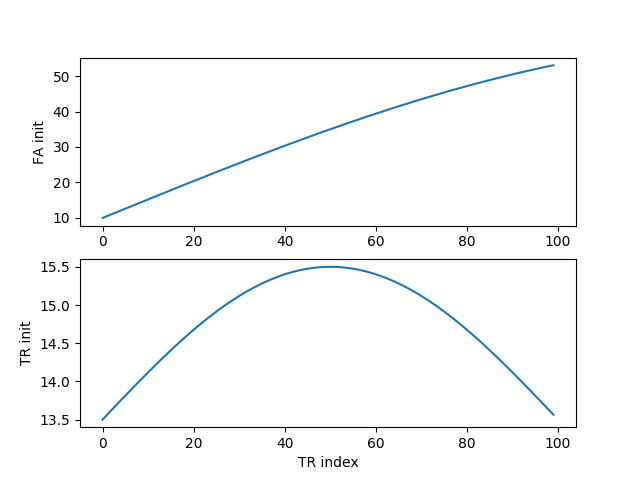

In [5]:
plt.figure()
plt.subplot(211)
plt.ylabel('FA init')
plt.plot(FAs_init)
plt.subplot(212)
plt.plot(TRs_init)
plt.ylabel('TR init')
plt.xlabel('TR index')
plt.show()

In [6]:
do_time_derivative = False

if(do_time_derivative):
    # time the derivative
    start = time.time()
    out_grads = crb_mrf_grad_efficient(array_init, *args_tmp)
    print("Elapsed Time efficient: " + str(time.time() - start))

    start = time.time()
    out_grads_numerical = crb_mrf_grad_numerical(array_init, *args_tmp)
    print("Elapsed Time numerical: " + str(time.time() - start))

    print("diff: " + str(np.sum(np.abs(out_grads - out_grads_numerical)))) # compare l1 norm of the gradients
    print(out_grads)
    print(out_grads_numerical)
    
# verify CRLB value
print(crb_mrf_objective_wrapper(array_init, *args_tmp))


4160.82041660845


In [7]:
# do the optimization
start = time.time()

opt_meta_data = OptimizationMetaData()
args = (M0, TEs, mrf_inversion_delay, T1, T2, opt_meta_data, None)

optimal_answer_intermediate, fx, its, imode, smode = scipy.optimize.fmin_slsqp(\
                          crb_mrf_objective_wrapper,                                                                                
                          array_init, 
                          bounds=bounds,
                          acc=1e-4,
                          iprint=2,
                          args=args,
                          iter=N_iters,
                          fprime=crb_mrf_grad_efficient,
                          f_ieqcons=f_ieqcons,
                          full_output=True)

optimal_split = np.split(optimal_answer_intermediate, 2)
optimal_FAs = optimal_split[0]
optimal_TRs = optimal_split[1]


elapsed_time_1 = time.time() - start

  NIT    FC           OBJFUN            GNORM


/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


    1     1     2.428139E+03     3.475279E+01
    2     2     2.121852E+03     2.543691E+01
    3     3     1.941276E+03     2.164880E+01
    4     4     1.762781E+03     1.807292E+01
    5     5     1.643074E+03     1.574784E+01
    6     6     1.499774E+03     1.295217E+01
    7     7     1.369739E+03     1.054221E+01
    8     8     1.279769E+03     9.204835E+00
    9     9     1.207345E+03     8.489036E+00
   10    10     1.200327E+03     8.465802E+00
   11    11     1.191194E+03     8.456852E+00
   12    12     1.184280E+03     8.462940E+00
   13    13     1.181115E+03     8.481396E+00
   14    14     1.179784E+03     8.492657E+00
   15    15     1.178541E+03     8.496382E+00
   16    16     1.176946E+03     8.489500E+00
   17    17     1.176482E+03     8.485184E+00
   18    18     1.175730E+03     8.477382E+00
   19    19     1.175369E+03     8.475727E+00
   20    20     1.174782E+03     8.485618E+00
   21    21     1.174652E+03     8.488653E+00
   22    22     1.174195E+03     8

<IPython.core.display.Javascript object>


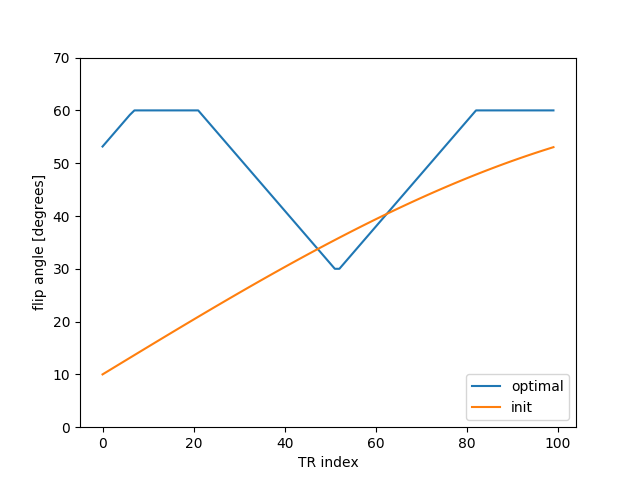

<IPython.core.display.Javascript object>


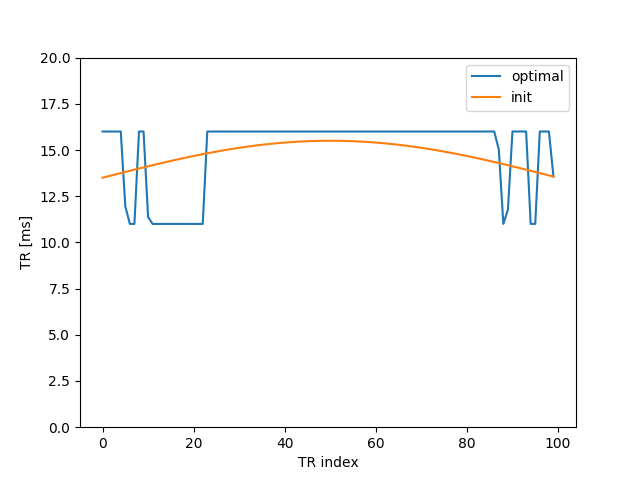

236.4390766620636
Optimization terminated successfully.


In [8]:
plt.figure()
plt.plot(optimal_FAs)
plt.plot(FAs_init)
plt.legend(('optimal', 'init'))
plt.ylim((0, 70))
plt.ylabel('flip angle [degrees]')
plt.xlabel('TR index')
plt.show()

plt.figure()
plt.plot(optimal_TRs)
plt.plot(TRs_init)
plt.legend(('optimal', 'init'))
plt.ylim((0, 20))
plt.ylabel('TR [ms]')
plt.xlabel('TR index')
plt.show()


print(elapsed_time_1)
print(smode)

In [9]:
print(fx)
print(its)

1172.8818611853455
57
